### Imports

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation , GRU,Bidirectional,Embedding,Concatenate,TimeDistributed,Flatten,BatchNormalization,Dropout
from wordcloud import WordCloud
import random
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
import seaborn as sns
from keras import optimizers
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix ,auc
from sklearn import metrics
from sklearn.metrics import plot_roc_curve


### Functions

In [4]:
def preprocessing(set):
    set["word_vector"]=set["word_vector"].apply(lambda x:eval(x))
    set["mean_vector"]=set["word_vector"].apply(lambda x:np.mean(x,axis=0))
    set["num_of_words"]=set["word_vector"].map(lambda x:len(x))
    set["wordvector_numofwords"]=set.apply(lambda x:x['mean_vector'].tolist()+[x["num_of_words"]],axis=1)
    set["wordvector_category"]=set.apply(lambda x:x['mean_vector'].tolist()+[x["category"]],axis=1)
    set["wordvector_category_numofwords"]=set.apply(lambda x:x['mean_vector'].tolist()+[x["category"]+x['num_of_words']],axis=1)
    return set
def plotROC(tprs,aucs,ax,fig):
    mean_fpr = np.linspace(0, 1, 100)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="AUC Curve")
    ax.legend(loc="lower right")
    plt.show()

### Models

In [5]:
def vanilla_rnn_0():
    model = Sequential()
    model.add(SimpleRNN(101, input_shape = (100,1), return_sequences = False))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model
def vanilla_rnn_1():
    model = Sequential()
    model.add(SimpleRNN(102, input_shape = (101,1), return_sequences = False))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model
def gru_model_0():
    model = Sequential()
    model.add(GRU(101, input_shape = (100,1), return_sequences = False))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
def gru_model_1():
    model = Sequential()
    model.add(GRU(102, input_shape = (101,1), return_sequences = False))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model


def BILSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(1024, return_sequences=False), input_shape=(101, 1)))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(learning_rate= 0.001)
    model.compile(loss='categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
    return model

# With custom backward layer
def BILSTMBK():
    adam = optimizers.Adam(learning_rate= 0.01)
    model = Sequential()
    forward_layer = LSTM(101, return_sequences=False)
    backward_layer = LSTM(101, activation='relu', return_sequences=False,
                        go_backwards=True)
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer,
                            input_shape=(100, 1)))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer = adam,metrics = ['accuracy'])
    return model

### Reading the data

In [9]:
train = pd.read_csv('Training.tsv', sep='\t')
# C:\Users\mm\Desktop\cs final project\Training
# test = pd.read_csv('C:/Users/mm/Desktop/cs final project/Testing/Testing.tsv', sep='\t')

### Preprocessing data

In [10]:
new_train=preprocessing(train)
# new_test=preprocessing(test)

In [11]:
new_train=new_train.drop(["Unnamed: 0"],axis=1)
# new_test=new_test.drop(["Unnamed: 0"],axis=1)

In [12]:
train_data=new_train.drop(["label"],axis=1)

In [13]:
xdraw=np.array(train_data["word_vector"].tolist()) 
X=np.array(train_data["mean_vector"].tolist())                     ##100 dim
X2=np.array(train_data["wordvector_numofwords"].tolist())          ##101 dim
X3=np.array(train_data["wordvector_category"].tolist())            ##101 dim
X4=np.array(train_data["wordvector_category_numofwords"].tolist()) ##101 dim
train_label=new_train["label"].map(lambda x:x-1).astype(int)

C:\Users\mm\AppData\Local\Temp/ipykernel_11440/3389996596.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xdraw=np.array(train_data["word_vector"].tolist())


<AxesSubplot:ylabel='label'>

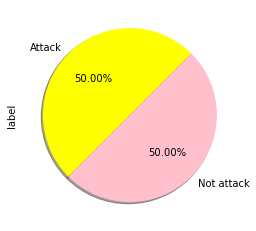

In [17]:
new_train['label'].value_counts().plot.pie(labels=['Attack', 'Not attack'], autopct = '%1.2f%%',shadow = True, startangle=45,colors = ['yellow','pink'])

In [29]:
new_train.isnull().value_counts()

category  word_vector  label  mean_vector  num_of_words  wordvector_numofwords  wordvector_category  wordvector_category_numofwords
False     False        False  False        False         False                  False                False                             123040
dtype: int64

#### Visualization

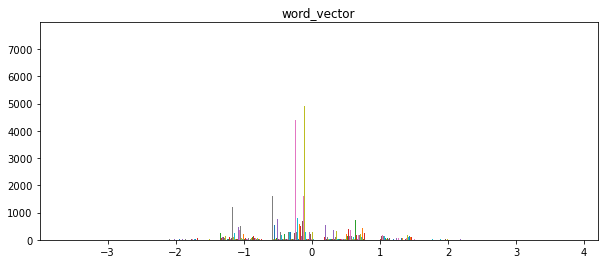

In [31]:
plt.figure(figsize =(10, 4))
plt.hist(xdraw)
plt.title("word_vector")
plt.show()

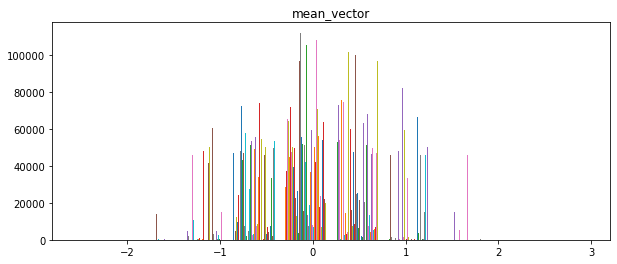

In [32]:
plt.figure(figsize =(10, 4))
plt.hist(X)
plt.title("mean_vector")
plt.show()

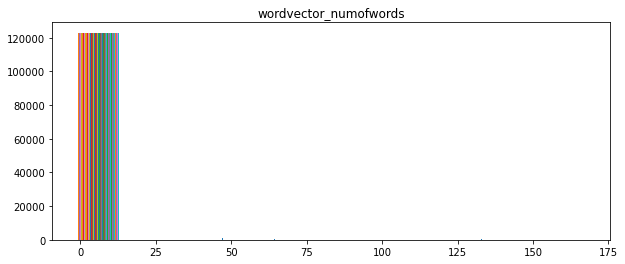

In [33]:
plt.figure(figsize =(10, 4))
plt.hist(X2)
plt.title("wordvector_numofwords")
plt.show()

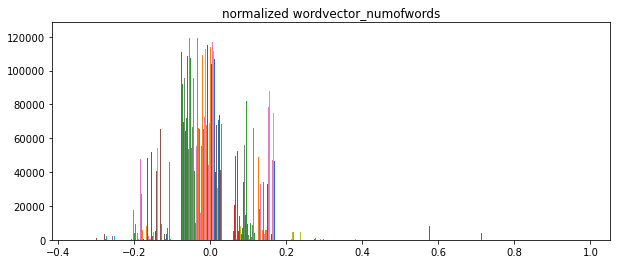

In [34]:
plt.figure(figsize =(10, 4))
plt.hist(normalize(X2))
plt.title("normalized wordvector_numofwords")
plt.show()

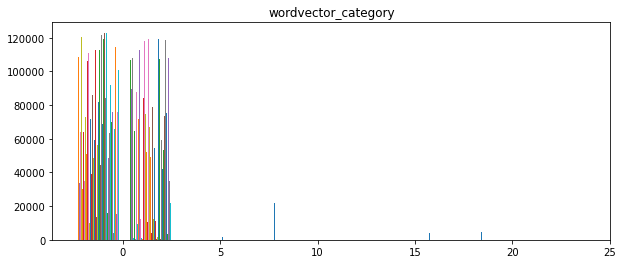

In [35]:
plt.figure(figsize =(10, 4))
plt.hist(X3)
plt.title("wordvector_category")
plt.show()

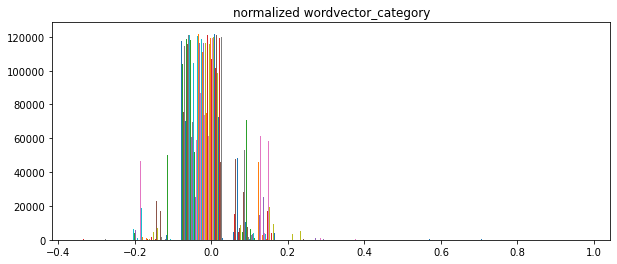

In [36]:
plt.figure(figsize =(10, 4))
plt.hist(normalize(X3))
plt.title("normalized wordvector_category")
plt.show()

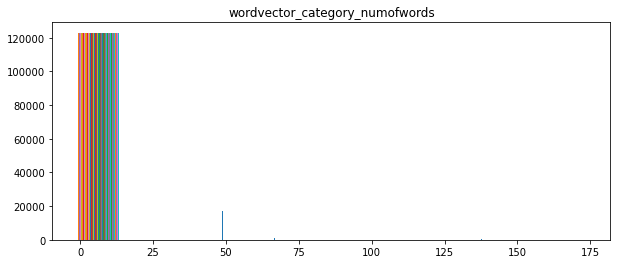

In [37]:
plt.figure(figsize =(10, 4))
plt.hist(X4)
plt.title("wordvector_category_numofwords")
plt.show()

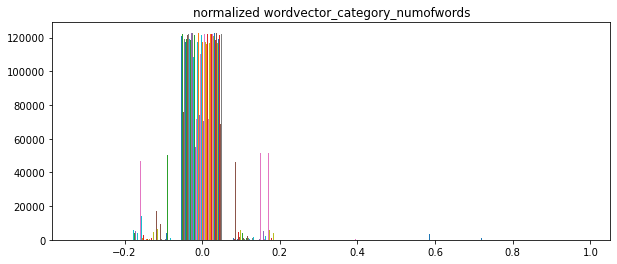

In [38]:
plt.figure(figsize =(10, 4))
plt.hist(normalize(X4))
plt.title("normalized wordvector_category_numofwords")
plt.show()

### Baseline Models

#### Vanilla RNN 

In [32]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3,mode="auto")

In [16]:
cv = StratifiedKFold(n_splits=5)
classifier_vrnn = KerasClassifier(build_fn=vanilla_rnn_0, 
                                 epochs=10, 
                                 batch_size=1024, 
                                 verbose=2)
classifier_vrnn._estimator_type = "classifier"

C:\Users\mm\AppData\Local\Temp/ipykernel_11440/3977792472.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier_vrnn = KerasClassifier(build_fn=vanilla_rnn_0,


Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 101s - loss: 0.4906 - accuracy: 0.7131 - 101s/epoch - 1s/step
Epoch 2/10
97/97 - 88s - loss: 0.4014 - accuracy: 0.7553 - 88s/epoch - 906ms/step
Epoch 3/10
97/97 - 85s - loss: 0.3715 - accuracy: 0.7687 - 85s/epoch - 881ms/step
Epoch 4/10
97/97 - 87s - loss: 0.3559 - accuracy: 0.7747 - 87s/epoch - 902ms/step
Epoch 5/10
97/97 - 88s - loss: 0.3449 - accuracy: 0.7811 - 88s/epoch - 905ms/step
Epoch 6/10
97/97 - 89s - loss: 0.5088 - accuracy: 0.6968 - 89s/epoch - 917ms/step
Epoch 7/10
97/97 - 87s - loss: 0.5134 - accuracy: 0.7053 - 87s/epoch - 894ms/step
Epoch 8/10
97/97 - 86s - loss: 0.4232 - accuracy: 0.7453 - 86s/epoch - 891ms/step
  1/769 [..............................] - ETA: 1:48

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 17s 23ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 87s - loss: 0.4955 - accuracy: 0.7093 - 87s/epoch - 894ms/step
Epoch 2/10
97/97 - 89s - loss: 0.4100 - accuracy: 0.7510 - 89s/epoch - 923ms/step
Epoch 3/10
97/97 - 89s - loss: 0.3916 - accuracy: 0.7574 - 89s/epoch - 919ms/step
Epoch 4/10
97/97 - 83s - loss: 0.3603 - accuracy: 0.7714 - 83s/epoch - 860ms/step
Epoch 5/10
97/97 - 81s - loss: 0.3595 - accuracy: 0.7737 - 81s/epoch - 836ms/step
Epoch 6/10
97/97 - 84s - loss: 0.3390 - accuracy: 0.7832 - 84s/epoch - 869ms/step
Epoch 7/10
97/97 - 84s - loss: 0.3390 - accuracy: 0.7823 - 84s/epoch - 870ms/step
Epoch 8/10
97/97 - 88s - loss: 0.3301 - accuracy: 0.7882 - 88s/epoch - 910ms/step
Epoch 9/10
97/97 - 89s - loss: 0.3280 - accuracy: 0.7881 - 89s/epoch - 916ms/step
Epoch 10/10
97/97 - 90s - loss: 0.3274 - accuracy: 0.7875 - 90s/epoch - 925ms/step
  1/769 [..............................] - ETA: 2:11

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 17s 22ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 93s - loss: 0.5110 - accuracy: 0.6961 - 93s/epoch - 957ms/step
Epoch 2/10
97/97 - 90s - loss: 0.4021 - accuracy: 0.7553 - 90s/epoch - 926ms/step
Epoch 3/10
97/97 - 89s - loss: 0.3770 - accuracy: 0.7648 - 89s/epoch - 918ms/step
Epoch 4/10
97/97 - 93s - loss: 0.3946 - accuracy: 0.7568 - 93s/epoch - 955ms/step
Epoch 5/10
97/97 - 89s - loss: 0.3620 - accuracy: 0.7719 - 89s/epoch - 919ms/step
Epoch 6/10
97/97 - 87s - loss: 0.3453 - accuracy: 0.7810 - 87s/epoch - 895ms/step
Epoch 7/10
97/97 - 90s - loss: 0.3433 - accuracy: 0.7797 - 90s/epoch - 930ms/step
Epoch 8/10
97/97 - 87s - loss: 0.3517 - accuracy: 0.7767 - 87s/epoch - 892ms/step
Epoch 9/10
97/97 - 87s - loss: 0.4303 - accuracy: 0.7434 - 87s/epoch - 898ms/step
Epoch 10/10
97/97 - 89s - loss: 0.3917 - accuracy: 0.7623 - 89s/epoch - 914ms/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 16s 21ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 88s - loss: 0.5025 - accuracy: 0.7019 - 88s/epoch - 905ms/step
Epoch 2/10
97/97 - 92s - loss: 0.4899 - accuracy: 0.7102 - 92s/epoch - 947ms/step
Epoch 3/10
97/97 - 87s - loss: 0.4039 - accuracy: 0.7545 - 87s/epoch - 899ms/step
Epoch 4/10
97/97 - 88s - loss: 0.3721 - accuracy: 0.7680 - 88s/epoch - 908ms/step
Epoch 5/10
97/97 - 87s - loss: 0.3912 - accuracy: 0.7623 - 87s/epoch - 896ms/step
Epoch 6/10
97/97 - 89s - loss: 0.3547 - accuracy: 0.7761 - 89s/epoch - 922ms/step
Epoch 7/10
97/97 - 95s - loss: 0.3490 - accuracy: 0.7812 - 95s/epoch - 975ms/step
Epoch 8/10
97/97 - 87s - loss: 0.3422 - accuracy: 0.7824 - 87s/epoch - 897ms/step
Epoch 9/10
97/97 - 88s - loss: 0.3355 - accuracy: 0.7847 - 88s/epoch - 911ms/step
Epoch 10/10
97/97 - 85s - loss: 0.3443 - accuracy: 0.7794 - 85s/epoch - 872ms/step
  1/769 [..............................] - ETA: 1:57

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 18s 24ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 87s - loss: 0.5014 - accuracy: 0.6987 - 87s/epoch - 895ms/step
Epoch 2/10
97/97 - 87s - loss: 0.4234 - accuracy: 0.7423 - 87s/epoch - 902ms/step
Epoch 3/10
97/97 - 84s - loss: 0.3775 - accuracy: 0.7656 - 84s/epoch - 862ms/step
Epoch 4/10
97/97 - 83s - loss: 0.3531 - accuracy: 0.7768 - 83s/epoch - 860ms/step
Epoch 5/10
97/97 - 87s - loss: 0.3448 - accuracy: 0.7810 - 87s/epoch - 894ms/step
Epoch 6/10
97/97 - 88s - loss: 0.3394 - accuracy: 0.7808 - 88s/epoch - 905ms/step
Epoch 7/10
97/97 - 85s - loss: 0.3739 - accuracy: 0.7671 - 85s/epoch - 880ms/step
Epoch 8/10
97/97 - 85s - loss: 0.3402 - accuracy: 0.7804 - 85s/epoch - 878ms/step
Epoch 9/10
97/97 - 88s - loss: 0.3327 - accuracy: 0.7856 - 88s/epoch - 904ms/step
Epoch 10/10
97/97 - 90s - loss: 0.3296 - accuracy: 0.7858 - 90s/epoch - 923ms/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 16s 21ms/step


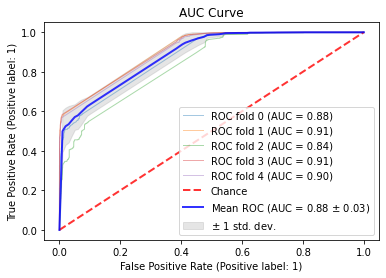

In [164]:
tprs_baseline = []
aucs_baseline = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, train_label)):
    mod=classifier_vrnn.fit(X[train],train_label[train],callbacks=[callbacks],verbose=2)
    viz = plot_roc_curve(classifier_vrnn, X[test], train_label[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.4, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_baseline.append(interp_tpr)
    aucs_baseline.append(viz.roc_auc)
plotROC(tprs_baseline,aucs_baseline,ax,fig)

#### Vanilla RNN 

In [168]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3,mode="auto")
cv = StratifiedKFold(n_splits=5)
classifier_vrnn = KerasClassifier(build_fn=vanilla_rnn_1, 
                                 epochs=10, 
                                 batch_size=1024, 
                                 verbose=2)
classifier_vrnn._estimator_type = "classifier"

C:\Users\mm\AppData\Local\Temp/ipykernel_10628/1622420798.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier_vrnn = KerasClassifier(build_fn=vanilla_rnn_1,


Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 78s - loss: 0.5211 - accuracy: 0.6934 - 78s/epoch - 804ms/step
Epoch 2/10
97/97 - 69s - loss: 0.4026 - accuracy: 0.7546 - 69s/epoch - 711ms/step
Epoch 3/10
97/97 - 69s - loss: 0.4304 - accuracy: 0.7399 - 69s/epoch - 712ms/step
Epoch 4/10
97/97 - 69s - loss: 0.3666 - accuracy: 0.7696 - 69s/epoch - 710ms/step
Epoch 5/10
97/97 - 69s - loss: 0.3608 - accuracy: 0.7725 - 69s/epoch - 711ms/step
Epoch 6/10
97/97 - 69s - loss: 0.3477 - accuracy: 0.7790 - 69s/epoch - 711ms/step
Epoch 7/10
97/97 - 69s - loss: 0.4070 - accuracy: 0.7538 - 69s/epoch - 709ms/step
Epoch 8/10
97/97 - 69s - loss: 0.5887 - accuracy: 0.6535 - 69s/epoch - 711ms/step
Epoch 9/10
97/97 - 69s - loss: 0.5947 - accuracy: 0.6588 - 69s/epoch - 711ms/step
  1/769 [..............................] - ETA: 1:41

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 15s 19ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 69s - loss: 0.5346 - accuracy: 0.6941 - 69s/epoch - 713ms/step
Epoch 2/10
97/97 - 69s - loss: 0.4329 - accuracy: 0.7404 - 69s/epoch - 708ms/step
Epoch 3/10
97/97 - 69s - loss: 0.4078 - accuracy: 0.7449 - 69s/epoch - 708ms/step
Epoch 4/10
97/97 - 69s - loss: 0.3754 - accuracy: 0.7655 - 69s/epoch - 710ms/step
Epoch 5/10
97/97 - 69s - loss: 0.5295 - accuracy: 0.6787 - 69s/epoch - 708ms/step
Epoch 6/10
97/97 - 69s - loss: 0.6066 - accuracy: 0.6438 - 69s/epoch - 707ms/step
Epoch 7/10
97/97 - 69s - loss: 0.5778 - accuracy: 0.6656 - 69s/epoch - 711ms/step
  1/769 [..............................] - ETA: 1:42

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 15s 19ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 69s - loss: 0.4939 - accuracy: 0.7199 - 69s/epoch - 712ms/step
Epoch 2/10
97/97 - 68s - loss: 0.3998 - accuracy: 0.7539 - 68s/epoch - 704ms/step
Epoch 3/10
97/97 - 68s - loss: 0.3719 - accuracy: 0.7677 - 68s/epoch - 705ms/step
Epoch 4/10
97/97 - 69s - loss: 0.3541 - accuracy: 0.7755 - 69s/epoch - 707ms/step
Epoch 5/10
97/97 - 69s - loss: 0.3699 - accuracy: 0.7656 - 69s/epoch - 707ms/step
Epoch 6/10
97/97 - 68s - loss: 0.3522 - accuracy: 0.7759 - 68s/epoch - 705ms/step
Epoch 7/10
97/97 - 68s - loss: 0.3435 - accuracy: 0.7798 - 68s/epoch - 705ms/step
Epoch 8/10
97/97 - 68s - loss: 0.3355 - accuracy: 0.7835 - 68s/epoch - 705ms/step
Epoch 9/10
97/97 - 68s - loss: 0.3322 - accuracy: 0.7851 - 68s/epoch - 706ms/step
Epoch 10/10
97/97 - 68s - loss: 0.3274 - accuracy: 0.7880 - 68s/epoch - 705ms/step
  1/769 [..............................] - ETA: 1:42

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 15s 19ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 69s - loss: 0.5429 - accuracy: 0.6895 - 69s/epoch - 710ms/step
Epoch 2/10
97/97 - 68s - loss: 0.4091 - accuracy: 0.7505 - 68s/epoch - 704ms/step
Epoch 3/10
97/97 - 68s - loss: 0.4405 - accuracy: 0.7345 - 68s/epoch - 703ms/step
Epoch 4/10
97/97 - 68s - loss: 0.3818 - accuracy: 0.7620 - 68s/epoch - 704ms/step
Epoch 5/10
97/97 - 68s - loss: 0.6018 - accuracy: 0.6605 - 68s/epoch - 704ms/step
Epoch 6/10
97/97 - 68s - loss: 0.6320 - accuracy: 0.6229 - 68s/epoch - 705ms/step
Epoch 7/10
97/97 - 68s - loss: 0.6173 - accuracy: 0.6350 - 68s/epoch - 704ms/step
  1/769 [..............................] - ETA: 1:39

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 15s 19ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 69s - loss: 0.5239 - accuracy: 0.6895 - 69s/epoch - 712ms/step
Epoch 2/10
97/97 - 68s - loss: 0.4300 - accuracy: 0.7401 - 68s/epoch - 706ms/step
Epoch 3/10
97/97 - 69s - loss: 0.6313 - accuracy: 0.6391 - 69s/epoch - 708ms/step
Epoch 4/10
97/97 - 68s - loss: 0.5705 - accuracy: 0.6767 - 68s/epoch - 706ms/step
Epoch 5/10
97/97 - 69s - loss: 0.5586 - accuracy: 0.6755 - 69s/epoch - 707ms/step
  1/769 [..............................] - ETA: 1:40

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 15s 19ms/step


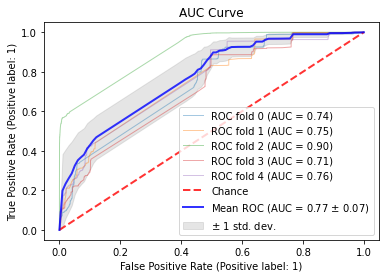

In [169]:
tprs_baseline = []
aucs_baseline = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X2, train_label)):
    mod0=classifier_vrnn.fit(X2[train],train_label[train],callbacks=[callbacks])
    viz = plot_roc_curve(classifier_vrnn, X2[test], train_label[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.4, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_baseline.append(interp_tpr)
    aucs_baseline.append(viz.roc_auc)
plotROC(tprs_baseline,aucs_baseline,ax,fig)

#### Vanilla RNN 

In [170]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3,mode="auto")
cv = StratifiedKFold(n_splits=5)
classifier_vrnn = KerasClassifier(build_fn=vanilla_rnn_1, 
                                 epochs=10, 
                                 batch_size=1024, 
                                 verbose=2)
classifier_vrnn._estimator_type = "classifier"

C:\Users\mm\AppData\Local\Temp/ipykernel_10628/1622420798.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier_vrnn = KerasClassifier(build_fn=vanilla_rnn_1,


Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 69s - loss: 0.5369 - accuracy: 0.6977 - 69s/epoch - 716ms/step
Epoch 2/10
97/97 - 69s - loss: 0.3984 - accuracy: 0.7582 - 69s/epoch - 707ms/step
Epoch 3/10
97/97 - 69s - loss: 0.3812 - accuracy: 0.7642 - 69s/epoch - 707ms/step
Epoch 4/10
97/97 - 69s - loss: 0.3469 - accuracy: 0.7799 - 69s/epoch - 707ms/step
Epoch 5/10
97/97 - 69s - loss: 0.3618 - accuracy: 0.7739 - 69s/epoch - 707ms/step
Epoch 6/10
97/97 - 69s - loss: 0.3393 - accuracy: 0.7816 - 69s/epoch - 708ms/step
Epoch 7/10
97/97 - 68s - loss: 0.3490 - accuracy: 0.7784 - 68s/epoch - 706ms/step
Epoch 8/10
97/97 - 69s - loss: 0.3341 - accuracy: 0.7839 - 69s/epoch - 706ms/step
Epoch 9/10
97/97 - 69s - loss: 0.3290 - accuracy: 0.7867 - 69s/epoch - 707ms/step
Epoch 10/10
97/97 - 69s - loss: 0.3264 - accuracy: 0.7864 - 69s/epoch - 707ms/step
  1/769 [..............................] - ETA: 1:43

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 14s 19ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 69s - loss: 0.5393 - accuracy: 0.6876 - 69s/epoch - 712ms/step
Epoch 2/10
97/97 - 68s - loss: 0.4236 - accuracy: 0.7411 - 68s/epoch - 704ms/step
Epoch 3/10
97/97 - 68s - loss: 0.3758 - accuracy: 0.7665 - 68s/epoch - 705ms/step
Epoch 4/10
97/97 - 68s - loss: 0.3680 - accuracy: 0.7697 - 68s/epoch - 706ms/step
Epoch 5/10
97/97 - 68s - loss: 0.3403 - accuracy: 0.7834 - 68s/epoch - 705ms/step
Epoch 6/10
97/97 - 68s - loss: 0.3586 - accuracy: 0.7735 - 68s/epoch - 705ms/step
Epoch 7/10
97/97 - 68s - loss: 0.3535 - accuracy: 0.7773 - 68s/epoch - 705ms/step
Epoch 8/10
97/97 - 69s - loss: 0.3358 - accuracy: 0.7834 - 69s/epoch - 706ms/step
Epoch 9/10
97/97 - 68s - loss: 0.3273 - accuracy: 0.7884 - 68s/epoch - 705ms/step
Epoch 10/10
97/97 - 68s - loss: 0.3273 - accuracy: 0.7883 - 68s/epoch - 705ms/step
  1/769 [..............................] - ETA: 1:50

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 15s 19ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 69s - loss: 0.6299 - accuracy: 0.6351 - 69s/epoch - 710ms/step
Epoch 2/10
97/97 - 68s - loss: 0.5673 - accuracy: 0.6881 - 68s/epoch - 703ms/step
Epoch 3/10
97/97 - 68s - loss: 0.4390 - accuracy: 0.7381 - 68s/epoch - 703ms/step
Epoch 4/10
97/97 - 68s - loss: 0.3921 - accuracy: 0.7638 - 68s/epoch - 703ms/step
Epoch 5/10
97/97 - 68s - loss: 0.3720 - accuracy: 0.7709 - 68s/epoch - 704ms/step
Epoch 6/10
97/97 - 70s - loss: 0.4169 - accuracy: 0.7485 - 70s/epoch - 722ms/step
Epoch 7/10
97/97 - 68s - loss: 0.3825 - accuracy: 0.7669 - 68s/epoch - 705ms/step
Epoch 8/10
97/97 - 68s - loss: 0.3514 - accuracy: 0.7799 - 68s/epoch - 700ms/step
Epoch 9/10
97/97 - 68s - loss: 0.3544 - accuracy: 0.7776 - 68s/epoch - 704ms/step
Epoch 10/10
97/97 - 68s - loss: 0.3432 - accuracy: 0.7807 - 68s/epoch - 700ms/step
  1/769 [..............................] - ETA: 1:37

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 14s 18ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 69s - loss: 0.5551 - accuracy: 0.6867 - 69s/epoch - 707ms/step
Epoch 2/10
97/97 - 68s - loss: 0.4907 - accuracy: 0.7189 - 68s/epoch - 698ms/step
Epoch 3/10
97/97 - 68s - loss: 0.4315 - accuracy: 0.7423 - 68s/epoch - 701ms/step
Epoch 4/10
97/97 - 68s - loss: 0.4701 - accuracy: 0.7246 - 68s/epoch - 699ms/step
Epoch 5/10
97/97 - 68s - loss: 0.3961 - accuracy: 0.7558 - 68s/epoch - 699ms/step
Epoch 6/10
97/97 - 68s - loss: 0.4074 - accuracy: 0.7537 - 68s/epoch - 699ms/step
Epoch 7/10
97/97 - 68s - loss: 0.3648 - accuracy: 0.7717 - 68s/epoch - 699ms/step
Epoch 8/10
97/97 - 68s - loss: 0.3496 - accuracy: 0.7774 - 68s/epoch - 700ms/step
Epoch 9/10
97/97 - 68s - loss: 0.3830 - accuracy: 0.7642 - 68s/epoch - 699ms/step
Epoch 10/10
97/97 - 68s - loss: 0.3821 - accuracy: 0.7650 - 68s/epoch - 698ms/step
  1/769 [..............................] - ETA: 1:40

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 14s 18ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 68s - loss: 0.5246 - accuracy: 0.7022 - 68s/epoch - 704ms/step
Epoch 2/10
97/97 - 68s - loss: 0.3994 - accuracy: 0.7577 - 68s/epoch - 697ms/step
Epoch 3/10
97/97 - 68s - loss: 0.3668 - accuracy: 0.7712 - 68s/epoch - 697ms/step
Epoch 4/10
97/97 - 68s - loss: 0.3663 - accuracy: 0.7719 - 68s/epoch - 697ms/step
Epoch 5/10
97/97 - 68s - loss: 0.3703 - accuracy: 0.7718 - 68s/epoch - 701ms/step
Epoch 6/10
97/97 - 68s - loss: 0.3586 - accuracy: 0.7754 - 68s/epoch - 699ms/step
Epoch 7/10
97/97 - 68s - loss: 0.3609 - accuracy: 0.7728 - 68s/epoch - 697ms/step
Epoch 8/10
97/97 - 68s - loss: 0.3410 - accuracy: 0.7805 - 68s/epoch - 698ms/step
Epoch 9/10
97/97 - 68s - loss: 0.3354 - accuracy: 0.7844 - 68s/epoch - 698ms/step
Epoch 10/10
97/97 - 68s - loss: 0.4074 - accuracy: 0.7525 - 68s/epoch - 701ms/step
  1/769 [..............................] - ETA: 1:39

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 14s 18ms/step


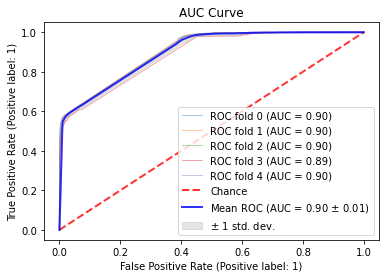

In [171]:
tprs_baseline = []
aucs_baseline = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X3, train_label)):
    classifier_vrnn.fit(X3[train],train_label[train],callbacks=[callbacks])
    viz = plot_roc_curve(classifier_vrnn, X3[test], train_label[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.4, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_baseline.append(interp_tpr)
    aucs_baseline.append(viz.roc_auc)
plotROC(tprs_baseline,aucs_baseline,ax,fig)

#### Vanilla RNN 

In [172]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3,mode="auto")
cv = StratifiedKFold(n_splits=5)
classifier_vrnn = KerasClassifier(build_fn=vanilla_rnn_1, 
                                 epochs=10, 
                                 batch_size=1024, 
                                 verbose=2)
classifier_vrnn._estimator_type = "classifier"

C:\Users\mm\AppData\Local\Temp/ipykernel_10628/1622420798.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier_vrnn = KerasClassifier(build_fn=vanilla_rnn_1,


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
97/97 - 68s - loss: 0.5186 - accuracy: 0.7021 - 68s/epoch - 703ms/step
Epoch 2/10
97/97 - 67s - loss: 0.3945 - accuracy: 0.7594 - 67s/epoch - 695ms/step
Epoch 3/10
97/97 - 67s - loss: 0.3706 - accuracy: 0.7710 - 67s/epoch - 695ms/step
Epoch 4/10
97/97 - 67s - loss: 0.3490 - accuracy: 0.7785 - 67s/epoch - 695ms/step
Epoch 5/10
97/97 - 67s - loss: 0.3447 - accuracy: 0.7808 - 67s/epoch - 695ms/step
Epoch 6/10
97/97 - 68s - loss: 0.3474 - accuracy: 0.7804 - 68s/epoch - 697ms/step
Epoch 7/10
97/97 - 68s - loss: 0.3320 - accuracy: 0.7858 - 68s/epoch - 697ms/step
Epoch 8/10
97/97 - 68s - loss: 0.3300 - accuracy: 0.7839 - 68s/epoch - 698ms/step
Epoch 9/10
97/97 - 67s - loss: 0.3280 - accuracy: 0.7870 - 67s/epoch - 695ms/step
Epoch 10/10
97/97 - 67s - loss: 0.3292 - accuracy: 0.7868 - 67s/epoch - 694ms/step
  1/769 [..............................] - ETA: 1:39

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 14s 18ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 68s - loss: 0.6344 - accuracy: 0.6429 - 68s/epoch - 699ms/step
Epoch 2/10
97/97 - 67s - loss: 0.5080 - accuracy: 0.7153 - 67s/epoch - 693ms/step
Epoch 3/10
97/97 - 67s - loss: 0.5319 - accuracy: 0.6942 - 67s/epoch - 692ms/step
Epoch 4/10
97/97 - 67s - loss: 0.4555 - accuracy: 0.7222 - 67s/epoch - 692ms/step
Epoch 5/10
97/97 - 67s - loss: 0.6415 - accuracy: 0.6311 - 67s/epoch - 692ms/step
Epoch 6/10
97/97 - 67s - loss: 0.6607 - accuracy: 0.6077 - 67s/epoch - 694ms/step
Epoch 7/10
97/97 - 68s - loss: 0.6089 - accuracy: 0.6617 - 68s/epoch - 703ms/step
  1/769 [..............................] - ETA: 1:37

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 15s 19ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 72s - loss: 0.5101 - accuracy: 0.7093 - 72s/epoch - 741ms/step
Epoch 2/10
97/97 - 68s - loss: 0.3846 - accuracy: 0.7639 - 68s/epoch - 700ms/step
Epoch 3/10
97/97 - 68s - loss: 0.4221 - accuracy: 0.7447 - 68s/epoch - 697ms/step
Epoch 4/10
97/97 - 68s - loss: 0.3740 - accuracy: 0.7674 - 68s/epoch - 697ms/step
Epoch 5/10
97/97 - 68s - loss: 0.3678 - accuracy: 0.7738 - 68s/epoch - 699ms/step
Epoch 6/10
97/97 - 68s - loss: 0.3518 - accuracy: 0.7781 - 68s/epoch - 702ms/step
Epoch 7/10
97/97 - 68s - loss: 0.3415 - accuracy: 0.7824 - 68s/epoch - 700ms/step
Epoch 8/10
97/97 - 68s - loss: 0.5701 - accuracy: 0.6820 - 68s/epoch - 698ms/step
Epoch 9/10
97/97 - 68s - loss: 0.5938 - accuracy: 0.6672 - 68s/epoch - 698ms/step
Epoch 10/10
97/97 - 68s - loss: 0.4448 - accuracy: 0.7391 - 68s/epoch - 698ms/step
  1/769 [..............................] - ETA: 1:45

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 14s 18ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 68s - loss: 0.5656 - accuracy: 0.6816 - 68s/epoch - 704ms/step
Epoch 2/10
97/97 - 68s - loss: 0.4561 - accuracy: 0.7262 - 68s/epoch - 697ms/step
Epoch 3/10
97/97 - 68s - loss: 0.3905 - accuracy: 0.7601 - 68s/epoch - 697ms/step
Epoch 4/10
97/97 - 68s - loss: 0.3961 - accuracy: 0.7546 - 68s/epoch - 698ms/step
Epoch 5/10
97/97 - 68s - loss: 0.4174 - accuracy: 0.7441 - 68s/epoch - 698ms/step
Epoch 6/10
97/97 - 68s - loss: 0.5228 - accuracy: 0.7040 - 68s/epoch - 697ms/step
  1/769 [..............................] - ETA: 1:44

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 14s 18ms/step
Epoch 1/10


c:\Users\mm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


97/97 - 68s - loss: 0.7651 - accuracy: 0.5557 - 68s/epoch - 699ms/step
Epoch 2/10
97/97 - 67s - loss: 0.6221 - accuracy: 0.6403 - 67s/epoch - 691ms/step
Epoch 3/10
97/97 - 67s - loss: 0.6687 - accuracy: 0.5823 - 67s/epoch - 694ms/step
Epoch 4/10
97/97 - 67s - loss: 0.5968 - accuracy: 0.6506 - 67s/epoch - 692ms/step
Epoch 5/10
97/97 - 67s - loss: 0.5606 - accuracy: 0.6708 - 67s/epoch - 693ms/step
Epoch 6/10
97/97 - 68s - loss: 0.5949 - accuracy: 0.6500 - 68s/epoch - 696ms/step
Epoch 7/10
97/97 - 67s - loss: 0.5505 - accuracy: 0.6799 - 67s/epoch - 694ms/step
Epoch 8/10
97/97 - 67s - loss: 0.5248 - accuracy: 0.6887 - 67s/epoch - 692ms/step
Epoch 9/10
97/97 - 68s - loss: 0.4546 - accuracy: 0.7303 - 68s/epoch - 702ms/step
Epoch 10/10
97/97 - 67s - loss: 0.4586 - accuracy: 0.7223 - 67s/epoch - 691ms/step
  1/769 [..............................] - ETA: 1:43

c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 14s 18ms/step


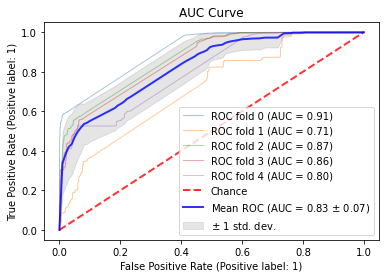

In [173]:
tprs_baseline = []
aucs_baseline = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X4, train_label)):
    classifier_vrnn.fit(X4[train],train_label[train],callbacks=[callbacks])
    viz = plot_roc_curve(classifier_vrnn, X4[test], train_label[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.4, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_baseline.append(interp_tpr)
    aucs_baseline.append(viz.roc_auc)
plotROC(tprs_baseline,aucs_baseline,ax,fig)

#### GRU Model

In [176]:
classifier_gru = KerasClassifier(build_fn=gru_model_0, 
                                 epochs=10, 
                                 batch_size=1024, 
                                 verbose=2)
classifier_gru._estimator_type = "classifier"

C:\Users\mm\AppData\Local\Temp/ipykernel_10628/257580780.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier_gru = KerasClassifier(build_fn=gru_model_0,


Epoch 1/10
97/97 - 190s - loss: 0.6498 - accuracy: 0.5932 - 190s/epoch - 2s/step
Epoch 2/10
97/97 - 180s - loss: 0.5589 - accuracy: 0.6619 - 180s/epoch - 2s/step
Epoch 3/10
97/97 - 180s - loss: 0.5198 - accuracy: 0.6941 - 180s/epoch - 2s/step
Epoch 4/10
97/97 - 184s - loss: 0.5263 - accuracy: 0.7013 - 184s/epoch - 2s/step
Epoch 5/10
97/97 - 180s - loss: 0.5585 - accuracy: 0.6852 - 180s/epoch - 2s/step
Epoch 6/10
97/97 - 180s - loss: 0.5142 - accuracy: 0.7115 - 180s/epoch - 2s/step
Epoch 7/10
97/97 - 180s - loss: 0.5412 - accuracy: 0.6903 - 180s/epoch - 2s/step
Epoch 8/10
97/97 - 180s - loss: 0.5569 - accuracy: 0.6570 - 180s/epoch - 2s/step
Epoch 9/10
97/97 - 180s - loss: 0.5089 - accuracy: 0.6984 - 180s/epoch - 2s/step
Epoch 10/10
97/97 - 180s - loss: 0.4721 - accuracy: 0.7287 - 180s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 56s 72ms/step
Epoch 1/10
97/97 - 170s - loss: 0.6518 - accuracy: 0.5875 - 170s/epoch - 2s/step
Epoch 2/10
97/97 - 170s - loss: 0.5727 - accuracy: 0.6507 - 170s/epoch - 2s/step
Epoch 3/10
97/97 - 169s - loss: 0.5393 - accuracy: 0.6829 - 169s/epoch - 2s/step
Epoch 4/10
97/97 - 169s - loss: 0.5400 - accuracy: 0.6940 - 169s/epoch - 2s/step
Epoch 5/10
97/97 - 169s - loss: 0.5369 - accuracy: 0.6825 - 169s/epoch - 2s/step
Epoch 6/10
97/97 - 169s - loss: 0.5165 - accuracy: 0.6848 - 169s/epoch - 2s/step
Epoch 7/10
97/97 - 169s - loss: 0.4886 - accuracy: 0.7041 - 169s/epoch - 2s/step
Epoch 8/10
97/97 - 169s - loss: 0.4812 - accuracy: 0.7101 - 169s/epoch - 2s/step
Epoch 9/10
97/97 - 169s - loss: 0.4779 - accuracy: 0.7141 - 169s/epoch - 2s/step
Epoch 10/10
97/97 - 169s - loss: 0.5012 - accuracy: 0.7159 - 169s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 52s 67ms/step
Epoch 1/10
97/97 - 170s - loss: 0.6546 - accuracy: 0.6061 - 170s/epoch - 2s/step
Epoch 2/10
97/97 - 168s - loss: 0.6029 - accuracy: 0.6545 - 168s/epoch - 2s/step
Epoch 3/10
97/97 - 167s - loss: 0.5939 - accuracy: 0.6548 - 167s/epoch - 2s/step
Epoch 4/10
97/97 - 168s - loss: 0.6125 - accuracy: 0.6194 - 168s/epoch - 2s/step
Epoch 5/10
97/97 - 168s - loss: 0.5359 - accuracy: 0.6983 - 168s/epoch - 2s/step
Epoch 6/10
97/97 - 168s - loss: 0.5035 - accuracy: 0.7187 - 168s/epoch - 2s/step
Epoch 7/10
97/97 - 168s - loss: 0.4816 - accuracy: 0.7248 - 168s/epoch - 2s/step
Epoch 8/10
97/97 - 168s - loss: 0.4696 - accuracy: 0.7284 - 168s/epoch - 2s/step
Epoch 9/10
97/97 - 168s - loss: 0.4597 - accuracy: 0.7339 - 168s/epoch - 2s/step
Epoch 10/10
97/97 - 167s - loss: 0.4517 - accuracy: 0.7348 - 167s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 53s 68ms/step
Epoch 1/10
97/97 - 166s - loss: 0.6632 - accuracy: 0.5886 - 166s/epoch - 2s/step
Epoch 2/10
97/97 - 165s - loss: 0.6269 - accuracy: 0.6409 - 165s/epoch - 2s/step
Epoch 3/10
97/97 - 165s - loss: 0.5868 - accuracy: 0.6681 - 165s/epoch - 2s/step
Epoch 4/10
97/97 - 165s - loss: 0.5367 - accuracy: 0.6732 - 165s/epoch - 2s/step
Epoch 5/10
97/97 - 165s - loss: 0.5127 - accuracy: 0.7066 - 165s/epoch - 2s/step
Epoch 6/10
97/97 - 165s - loss: 0.7165 - accuracy: 0.5893 - 165s/epoch - 2s/step
Epoch 7/10
97/97 - 165s - loss: 0.6282 - accuracy: 0.6186 - 165s/epoch - 2s/step
Epoch 8/10
97/97 - 165s - loss: 0.6029 - accuracy: 0.6388 - 165s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 51s 67ms/step
Epoch 1/10
97/97 - 157s - loss: 0.6551 - accuracy: 0.5897 - 157s/epoch - 2s/step
Epoch 2/10
97/97 - 159s - loss: 0.5907 - accuracy: 0.6431 - 159s/epoch - 2s/step
Epoch 3/10
97/97 - 160s - loss: 0.5208 - accuracy: 0.6978 - 160s/epoch - 2s/step
Epoch 4/10
97/97 - 159s - loss: 0.5058 - accuracy: 0.7172 - 159s/epoch - 2s/step
Epoch 5/10
97/97 - 159s - loss: 0.5046 - accuracy: 0.7169 - 159s/epoch - 2s/step
Epoch 6/10
97/97 - 159s - loss: 0.5639 - accuracy: 0.6614 - 159s/epoch - 2s/step
Epoch 7/10
97/97 - 159s - loss: 0.5281 - accuracy: 0.7010 - 159s/epoch - 2s/step
Epoch 8/10
97/97 - 159s - loss: 0.4917 - accuracy: 0.7120 - 159s/epoch - 2s/step
Epoch 9/10
97/97 - 160s - loss: 0.9045 - accuracy: 0.6306 - 160s/epoch - 2s/step
Epoch 10/10
97/97 - 160s - loss: 0.7575 - accuracy: 0.5622 - 160s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 49s 64ms/step


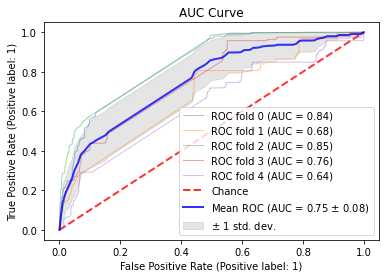

In [177]:
tprs_baseline0 = []
aucs_baseline0 = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, train_label)):
    classifier_gru.fit(X[train],train_label[train],callbacks=[callbacks])
    viz = plot_roc_curve(classifier_gru, X[test], train_label[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.4, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_baseline0.append(interp_tpr)
    aucs_baseline0.append(viz.roc_auc)
plotROC(tprs_baseline0,aucs_baseline0,ax,fig)

#### GRU Model

In [178]:
classifier_gru = KerasClassifier(build_fn=gru_model_1, 
                                 epochs=10, 
                                 batch_size=1024, 
                                 verbose=2)
classifier_gru._estimator_type = "classifier"

C:\Users\mm\AppData\Local\Temp/ipykernel_10628/489768887.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier_gru = KerasClassifier(build_fn=gru_model_1,


Epoch 1/10
97/97 - 144s - loss: 0.6404 - accuracy: 0.6181 - 144s/epoch - 1s/step
Epoch 2/10
97/97 - 142s - loss: 0.5679 - accuracy: 0.6678 - 142s/epoch - 1s/step
Epoch 3/10
97/97 - 142s - loss: 0.5942 - accuracy: 0.6455 - 142s/epoch - 1s/step
Epoch 4/10
97/97 - 143s - loss: 0.5286 - accuracy: 0.6936 - 143s/epoch - 1s/step
Epoch 5/10
97/97 - 144s - loss: 0.6290 - accuracy: 0.6644 - 144s/epoch - 1s/step
Epoch 6/10
97/97 - 144s - loss: 0.5571 - accuracy: 0.6878 - 144s/epoch - 1s/step
Epoch 7/10
97/97 - 144s - loss: 0.5448 - accuracy: 0.6797 - 144s/epoch - 1s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 60s 77ms/step
Epoch 1/10
97/97 - 136s - loss: 0.6480 - accuracy: 0.5971 - 136s/epoch - 1s/step
Epoch 2/10
97/97 - 135s - loss: 0.5719 - accuracy: 0.6576 - 135s/epoch - 1s/step
Epoch 3/10
97/97 - 135s - loss: 0.5432 - accuracy: 0.6853 - 135s/epoch - 1s/step
Epoch 4/10
97/97 - 135s - loss: 0.6080 - accuracy: 0.6466 - 135s/epoch - 1s/step
Epoch 5/10
97/97 - 136s - loss: 0.5482 - accuracy: 0.6565 - 136s/epoch - 1s/step
Epoch 6/10
97/97 - 136s - loss: 0.5155 - accuracy: 0.6994 - 136s/epoch - 1s/step
Epoch 7/10
97/97 - 136s - loss: 0.5541 - accuracy: 0.6892 - 136s/epoch - 1s/step
Epoch 8/10
97/97 - 135s - loss: 0.5554 - accuracy: 0.6806 - 135s/epoch - 1s/step
Epoch 9/10
97/97 - 136s - loss: 0.5797 - accuracy: 0.6554 - 136s/epoch - 1s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 54s 69ms/step
Epoch 1/10
97/97 - 137s - loss: 0.6404 - accuracy: 0.6057 - 137s/epoch - 1s/step
Epoch 2/10
97/97 - 136s - loss: 0.5761 - accuracy: 0.6539 - 136s/epoch - 1s/step
Epoch 3/10
97/97 - 136s - loss: 0.6153 - accuracy: 0.6554 - 136s/epoch - 1s/step
Epoch 4/10
97/97 - 136s - loss: 0.5606 - accuracy: 0.6781 - 136s/epoch - 1s/step
Epoch 5/10
97/97 - 136s - loss: 0.5076 - accuracy: 0.7073 - 136s/epoch - 1s/step
Epoch 6/10
97/97 - 136s - loss: 0.5068 - accuracy: 0.7126 - 136s/epoch - 1s/step
Epoch 7/10
97/97 - 136s - loss: 0.5367 - accuracy: 0.6948 - 136s/epoch - 1s/step
Epoch 8/10
97/97 - 137s - loss: 0.5773 - accuracy: 0.6630 - 137s/epoch - 1s/step
Epoch 9/10
97/97 - 136s - loss: 0.5353 - accuracy: 0.6811 - 136s/epoch - 1s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 60s 78ms/step
Epoch 1/10
97/97 - 184s - loss: 0.6503 - accuracy: 0.6083 - 184s/epoch - 2s/step
Epoch 2/10
97/97 - 189s - loss: 0.5976 - accuracy: 0.6510 - 189s/epoch - 2s/step
Epoch 3/10
97/97 - 187s - loss: 0.5439 - accuracy: 0.6867 - 187s/epoch - 2s/step
Epoch 4/10
97/97 - 189s - loss: 0.5437 - accuracy: 0.6831 - 189s/epoch - 2s/step
Epoch 5/10
97/97 - 187s - loss: 0.5321 - accuracy: 0.6907 - 187s/epoch - 2s/step
Epoch 6/10
97/97 - 187s - loss: 0.6536 - accuracy: 0.6188 - 187s/epoch - 2s/step
Epoch 7/10
97/97 - 187s - loss: 0.6397 - accuracy: 0.6424 - 187s/epoch - 2s/step
Epoch 8/10
97/97 - 187s - loss: 0.6211 - accuracy: 0.6488 - 187s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 71s 91ms/step
Epoch 1/10
97/97 - 187s - loss: 0.6376 - accuracy: 0.6046 - 187s/epoch - 2s/step
Epoch 2/10
97/97 - 185s - loss: 0.5512 - accuracy: 0.6829 - 185s/epoch - 2s/step
Epoch 3/10
97/97 - 185s - loss: 0.5298 - accuracy: 0.7008 - 185s/epoch - 2s/step
Epoch 4/10
97/97 - 190s - loss: 0.5283 - accuracy: 0.6983 - 190s/epoch - 2s/step
Epoch 5/10
97/97 - 186s - loss: 0.5402 - accuracy: 0.6986 - 186s/epoch - 2s/step
Epoch 6/10
97/97 - 186s - loss: 0.5218 - accuracy: 0.7062 - 186s/epoch - 2s/step
Epoch 7/10
97/97 - 190s - loss: 0.4927 - accuracy: 0.7267 - 190s/epoch - 2s/step
Epoch 8/10
97/97 - 186s - loss: 0.4865 - accuracy: 0.7240 - 186s/epoch - 2s/step
Epoch 9/10
97/97 - 186s - loss: 0.4876 - accuracy: 0.7187 - 186s/epoch - 2s/step
Epoch 10/10
97/97 - 187s - loss: 0.4584 - accuracy: 0.7327 - 187s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 71s 93ms/step


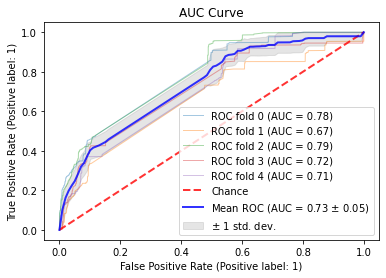

In [179]:
tprs_baseline0 = []
aucs_baseline0 = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X2, train_label)):
    classifier_gru.fit(X2[train],train_label[train],callbacks=[callbacks])
    viz = plot_roc_curve(classifier_gru, X2[test], train_label[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.4, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_baseline0.append(interp_tpr)
    aucs_baseline0.append(viz.roc_auc)
plotROC(tprs_baseline0,aucs_baseline0,ax,fig)

#### GRU Model

In [180]:
classifier_gru = KerasClassifier(build_fn=gru_model_1, 
                                 epochs=10, 
                                 batch_size=1024, 
                                 verbose=2)
classifier_gru._estimator_type = "classifier"

C:\Users\mm\AppData\Local\Temp/ipykernel_10628/489768887.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier_gru = KerasClassifier(build_fn=gru_model_1,


Epoch 1/10
97/97 - 188s - loss: 0.6635 - accuracy: 0.5816 - 188s/epoch - 2s/step
Epoch 2/10
97/97 - 182s - loss: 0.5592 - accuracy: 0.6895 - 182s/epoch - 2s/step
Epoch 3/10
97/97 - 182s - loss: 0.5328 - accuracy: 0.7040 - 182s/epoch - 2s/step
Epoch 4/10
97/97 - 182s - loss: 0.5157 - accuracy: 0.7142 - 182s/epoch - 2s/step
Epoch 5/10
97/97 - 182s - loss: 0.5045 - accuracy: 0.7199 - 182s/epoch - 2s/step
Epoch 6/10
97/97 - 182s - loss: 0.5056 - accuracy: 0.7119 - 182s/epoch - 2s/step
Epoch 7/10
97/97 - 182s - loss: 0.4815 - accuracy: 0.7291 - 182s/epoch - 2s/step
Epoch 8/10
97/97 - 182s - loss: 0.4980 - accuracy: 0.7248 - 182s/epoch - 2s/step
Epoch 9/10
97/97 - 182s - loss: 0.5787 - accuracy: 0.6496 - 182s/epoch - 2s/step
Epoch 10/10
97/97 - 183s - loss: 0.6625 - accuracy: 0.6098 - 183s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 69s 89ms/step
Epoch 1/10
97/97 - 183s - loss: 0.6656 - accuracy: 0.5790 - 183s/epoch - 2s/step
Epoch 2/10
97/97 - 178s - loss: 0.5665 - accuracy: 0.6795 - 178s/epoch - 2s/step
Epoch 3/10
97/97 - 176s - loss: 0.5470 - accuracy: 0.7042 - 176s/epoch - 2s/step
Epoch 4/10
97/97 - 176s - loss: 0.5501 - accuracy: 0.6756 - 176s/epoch - 2s/step
Epoch 5/10
97/97 - 177s - loss: 0.5172 - accuracy: 0.7210 - 177s/epoch - 2s/step
Epoch 6/10
97/97 - 177s - loss: 0.5564 - accuracy: 0.6729 - 177s/epoch - 2s/step
Epoch 7/10
97/97 - 177s - loss: 0.5106 - accuracy: 0.7118 - 177s/epoch - 2s/step
Epoch 8/10
97/97 - 176s - loss: 0.5678 - accuracy: 0.6600 - 176s/epoch - 2s/step
Epoch 9/10
97/97 - 177s - loss: 0.6749 - accuracy: 0.5675 - 177s/epoch - 2s/step
Epoch 10/10
97/97 - 176s - loss: 0.6414 - accuracy: 0.6554 - 176s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 67s 87ms/step
Epoch 1/10
97/97 - 176s - loss: 0.6562 - accuracy: 0.5857 - 176s/epoch - 2s/step
Epoch 2/10
97/97 - 175s - loss: 0.5434 - accuracy: 0.7021 - 175s/epoch - 2s/step
Epoch 3/10
97/97 - 178s - loss: 0.5312 - accuracy: 0.7005 - 178s/epoch - 2s/step
Epoch 4/10
97/97 - 179s - loss: 0.5264 - accuracy: 0.6933 - 179s/epoch - 2s/step
Epoch 5/10
97/97 - 181s - loss: 0.5096 - accuracy: 0.7131 - 181s/epoch - 2s/step
Epoch 6/10
97/97 - 179s - loss: 0.5624 - accuracy: 0.6776 - 179s/epoch - 2s/step
Epoch 7/10
97/97 - 179s - loss: 0.4964 - accuracy: 0.7125 - 179s/epoch - 2s/step
Epoch 8/10
97/97 - 179s - loss: 0.4972 - accuracy: 0.7156 - 179s/epoch - 2s/step
Epoch 9/10
97/97 - 179s - loss: 0.5203 - accuracy: 0.6946 - 179s/epoch - 2s/step
Epoch 10/10
97/97 - 180s - loss: 0.4857 - accuracy: 0.7172 - 180s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 70s 91ms/step
Epoch 1/10
97/97 - 182s - loss: 0.6643 - accuracy: 0.5882 - 182s/epoch - 2s/step
Epoch 2/10
97/97 - 176s - loss: 0.5768 - accuracy: 0.6694 - 176s/epoch - 2s/step
Epoch 3/10
97/97 - 176s - loss: 0.5163 - accuracy: 0.7269 - 176s/epoch - 2s/step
Epoch 4/10
97/97 - 176s - loss: 0.5301 - accuracy: 0.7108 - 176s/epoch - 2s/step
Epoch 5/10
97/97 - 176s - loss: 0.5176 - accuracy: 0.7130 - 176s/epoch - 2s/step
Epoch 6/10
97/97 - 176s - loss: 0.6532 - accuracy: 0.6743 - 176s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 65s 85ms/step
Epoch 1/10
97/97 - 175s - loss: 0.6959 - accuracy: 0.5555 - 175s/epoch - 2s/step
Epoch 2/10
97/97 - 173s - loss: 0.6079 - accuracy: 0.6513 - 173s/epoch - 2s/step
Epoch 3/10
97/97 - 174s - loss: 0.5384 - accuracy: 0.7027 - 174s/epoch - 2s/step
Epoch 4/10
97/97 - 173s - loss: 0.5038 - accuracy: 0.7154 - 173s/epoch - 2s/step
Epoch 5/10
97/97 - 174s - loss: 0.6611 - accuracy: 0.6119 - 174s/epoch - 2s/step
Epoch 6/10
97/97 - 174s - loss: 0.5844 - accuracy: 0.6820 - 174s/epoch - 2s/step
Epoch 7/10
97/97 - 173s - loss: 0.6087 - accuracy: 0.6399 - 173s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 65s 84ms/step


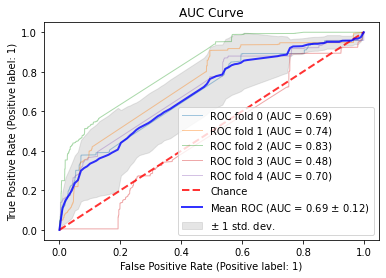

In [181]:
tprs_baseline0 = []
aucs_baseline0 = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X3, train_label)):
    classifier_gru.fit(X3[train],train_label[train],callbacks=[callbacks])
    viz = plot_roc_curve(classifier_gru, X3[test], train_label[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.4, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_baseline0.append(interp_tpr)
    aucs_baseline0.append(viz.roc_auc)
plotROC(tprs_baseline0,aucs_baseline0,ax,fig)

#### GRU Model

In [182]:
classifier_gru = KerasClassifier(build_fn=gru_model_1, 
                                 epochs=10, 
                                 batch_size=1024, 
                                 verbose=2)
classifier_gru._estimator_type = "classifier"

C:\Users\mm\AppData\Local\Temp/ipykernel_10628/489768887.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier_gru = KerasClassifier(build_fn=gru_model_1,


Epoch 1/10
97/97 - 175s - loss: 0.6411 - accuracy: 0.6061 - 175s/epoch - 2s/step
Epoch 2/10
97/97 - 173s - loss: 0.5552 - accuracy: 0.6978 - 173s/epoch - 2s/step
Epoch 3/10
97/97 - 173s - loss: 0.5221 - accuracy: 0.7156 - 173s/epoch - 2s/step
Epoch 4/10
97/97 - 173s - loss: 0.5086 - accuracy: 0.7177 - 173s/epoch - 2s/step
Epoch 5/10
97/97 - 173s - loss: 0.5701 - accuracy: 0.6774 - 173s/epoch - 2s/step
Epoch 6/10
97/97 - 173s - loss: 0.6776 - accuracy: 0.5423 - 173s/epoch - 2s/step
Epoch 7/10
97/97 - 172s - loss: 0.6653 - accuracy: 0.5852 - 172s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 64s 83ms/step
Epoch 1/10
97/97 - 172s - loss: 0.6335 - accuracy: 0.6153 - 172s/epoch - 2s/step
Epoch 2/10
97/97 - 170s - loss: 0.5566 - accuracy: 0.6904 - 170s/epoch - 2s/step
Epoch 3/10
97/97 - 171s - loss: 0.5144 - accuracy: 0.7198 - 171s/epoch - 2s/step
Epoch 4/10
97/97 - 170s - loss: 0.5667 - accuracy: 0.6844 - 170s/epoch - 2s/step
Epoch 5/10
97/97 - 170s - loss: 0.5240 - accuracy: 0.7052 - 170s/epoch - 2s/step
Epoch 6/10
97/97 - 171s - loss: 0.4983 - accuracy: 0.7252 - 171s/epoch - 2s/step
Epoch 7/10
97/97 - 171s - loss: 0.4853 - accuracy: 0.7279 - 171s/epoch - 2s/step
Epoch 8/10
97/97 - 171s - loss: 0.5050 - accuracy: 0.7075 - 171s/epoch - 2s/step
Epoch 9/10
97/97 - 171s - loss: 0.5323 - accuracy: 0.6976 - 171s/epoch - 2s/step
Epoch 10/10
97/97 - 172s - loss: 0.4729 - accuracy: 0.7302 - 172s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 63s 82ms/step
Epoch 1/10
97/97 - 173s - loss: 0.6572 - accuracy: 0.5860 - 173s/epoch - 2s/step
Epoch 2/10
97/97 - 171s - loss: 0.5590 - accuracy: 0.6880 - 171s/epoch - 2s/step
Epoch 3/10
97/97 - 171s - loss: 0.5447 - accuracy: 0.6948 - 171s/epoch - 2s/step
Epoch 4/10
97/97 - 171s - loss: 0.5457 - accuracy: 0.6875 - 171s/epoch - 2s/step
Epoch 5/10
97/97 - 171s - loss: 0.4915 - accuracy: 0.7262 - 171s/epoch - 2s/step
Epoch 6/10
97/97 - 171s - loss: 0.5491 - accuracy: 0.6881 - 171s/epoch - 2s/step
Epoch 7/10
97/97 - 171s - loss: 0.4935 - accuracy: 0.7181 - 171s/epoch - 2s/step
Epoch 8/10
97/97 - 171s - loss: 0.4726 - accuracy: 0.7307 - 171s/epoch - 2s/step
Epoch 9/10
97/97 - 171s - loss: 0.5481 - accuracy: 0.6921 - 171s/epoch - 2s/step
Epoch 10/10
97/97 - 170s - loss: 0.5022 - accuracy: 0.7116 - 170s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 62s 81ms/step
Epoch 1/10
97/97 - 170s - loss: 0.6861 - accuracy: 0.5475 - 170s/epoch - 2s/step
Epoch 2/10
97/97 - 169s - loss: 0.5638 - accuracy: 0.6840 - 169s/epoch - 2s/step
Epoch 3/10
97/97 - 169s - loss: 0.5329 - accuracy: 0.7035 - 169s/epoch - 2s/step
Epoch 4/10
97/97 - 169s - loss: 0.5360 - accuracy: 0.6972 - 169s/epoch - 2s/step
Epoch 5/10
97/97 - 169s - loss: 0.5636 - accuracy: 0.6761 - 169s/epoch - 2s/step
Epoch 6/10
97/97 - 169s - loss: 0.5110 - accuracy: 0.7136 - 169s/epoch - 2s/step
Epoch 7/10
97/97 - 169s - loss: 0.5166 - accuracy: 0.7042 - 169s/epoch - 2s/step
Epoch 8/10
97/97 - 169s - loss: 0.4779 - accuracy: 0.7247 - 169s/epoch - 2s/step
Epoch 9/10
97/97 - 169s - loss: 0.5296 - accuracy: 0.6939 - 169s/epoch - 2s/step
Epoch 10/10
97/97 - 169s - loss: 0.4839 - accuracy: 0.7261 - 169s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 62s 80ms/step
Epoch 1/10
97/97 - 170s - loss: 0.6527 - accuracy: 0.5930 - 170s/epoch - 2s/step
Epoch 2/10
97/97 - 168s - loss: 0.5490 - accuracy: 0.6895 - 168s/epoch - 2s/step
Epoch 3/10
97/97 - 169s - loss: 0.5227 - accuracy: 0.7064 - 169s/epoch - 2s/step
Epoch 4/10
97/97 - 169s - loss: 0.5775 - accuracy: 0.6701 - 169s/epoch - 2s/step
Epoch 5/10
97/97 - 169s - loss: 0.5094 - accuracy: 0.7193 - 169s/epoch - 2s/step
Epoch 6/10
97/97 - 169s - loss: 0.5724 - accuracy: 0.6735 - 169s/epoch - 2s/step
Epoch 7/10
97/97 - 169s - loss: 0.5657 - accuracy: 0.6533 - 169s/epoch - 2s/step
Epoch 8/10
97/97 - 168s - loss: 0.5435 - accuracy: 0.6598 - 168s/epoch - 2s/step


c:\Users\mm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


769/769 [==============================] - 62s 80ms/step


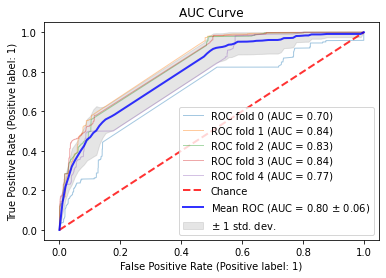

In [183]:
tprs_baseline0 = []
aucs_baseline0 = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X4, train_label)):
    classifier_gru.fit(X4[train],train_label[train],callbacks=[callbacks])
    viz = plot_roc_curve(classifier_gru, X4[test], train_label[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.4, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_baseline0.append(interp_tpr)
    aucs_baseline0.append(viz.roc_auc)
plotROC(tprs_baseline0,aucs_baseline0,ax,fig)

## Testing

### BILSTM Model

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, train_label, test_size=0.20, random_state=42,stratify=train_label)

In [20]:
classifier_BILSTM = KerasClassifier(build_fn=BILSTMBK, 
                                 epochs=5, 
                                 batch_size=512, 
                                 verbose=2)
classifier_BILSTM._estimator_type = "classifier"

C:\Users\mm\AppData\Local\Temp/ipykernel_11440/1951267801.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier_BILSTM = KerasClassifier(build_fn=BILSTMBK,


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="./maboe017/weights-improvement-best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint,tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3,mode="auto")]

In [99]:
history=classifier_BILSTM.fit(X_train,y_train,validation_steps =0.3,callbacks=[callbacks])

Epoch 1/50

Epoch 1: accuracy improved from -inf to 0.61163, saving model to ./maboe017/weights-improvement-best.hdf5
193/193 - 25s - loss: 1858118.8750 - accuracy: 0.6116 - 25s/epoch - 128ms/step
Epoch 2/50

Epoch 2: accuracy did not improve from 0.61163
193/193 - 23s - loss: 350509.6875 - accuracy: 0.5395 - 23s/epoch - 118ms/step
Epoch 3/50

Epoch 3: accuracy improved from 0.61163 to 0.65636, saving model to ./maboe017/weights-improvement-best.hdf5
193/193 - 22s - loss: 0.5873 - accuracy: 0.6564 - 22s/epoch - 116ms/step
Epoch 4/50

Epoch 4: accuracy improved from 0.65636 to 0.66731, saving model to ./maboe017/weights-improvement-best.hdf5
193/193 - 23s - loss: 0.5582 - accuracy: 0.6673 - 23s/epoch - 118ms/step
Epoch 5/50

Epoch 5: accuracy did not improve from 0.66731
193/193 - 23s - loss: 0.5756 - accuracy: 0.6588 - 23s/epoch - 118ms/step
Epoch 6/50

Epoch 6: accuracy improved from 0.66731 to 0.70036, saving model to ./maboe017/weights-improvement-best.hdf5
193/193 - 23s - loss: 0.5

In [95]:
# classifier_BILSTM.load_weights(filepath)
ypred=classifier_BILSTM.predict(X_test)

769/769 [==============================] - 12s 14ms/step


0.7480900520156046


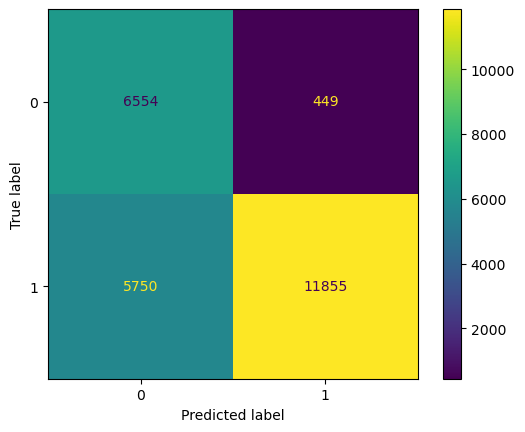

In [97]:
ConfusionMatrixDisplay(confusion_matrix(ypred, y_test)).plot()
print(accuracy_score(ypred,y_test))

In [103]:
print(classification_report(ypred, y_test))

              precision    recall  f1-score   support

           0       0.53      0.94      0.68      7003
           1       0.96      0.67      0.79     17605

    accuracy                           0.75     24608
   macro avg       0.75      0.80      0.74     24608
weighted avg       0.84      0.75      0.76     24608



#### Evaluations

In [107]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(0, 3)

In [104]:
Attack = new_train[new_train["label"]==1.0]
Benign = new_train[new_train["label"]==2.0]

In [105]:
countsA = Attack['num_of_words'].value_counts()
countsA.index = countsA.index.map(str)

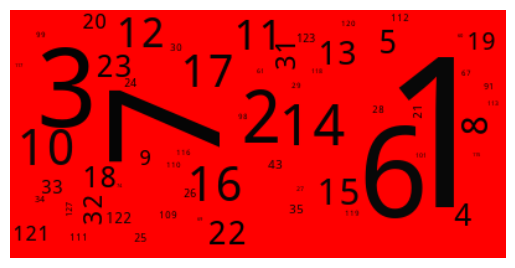

In [108]:
wordcloud = WordCloud(background_color="Red",color_func=grey_color_func).generate_from_frequencies(countsA)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [109]:
countsB = Benign['num_of_words'].value_counts()
countsB.index = countsB.index.map(str)

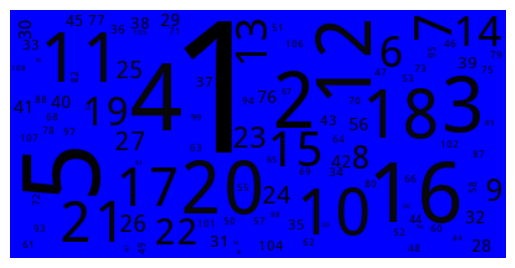

In [110]:
wordcloud = WordCloud(background_color="Blue",color_func=grey_color_func).generate_from_frequencies(countsB)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()